In this notebook we will be looking at another type of single-layer neural network called Adaptive Linear Neuron, or Adaline for short. Adaline is different from the perceptron we build before because instead of using a step function to update the weights, we use a linear activation function instead. From the book I can tell that this is going to be an important concept to grasp, as it is the gateway to a lot of other more advanced algorithms that supports more than just binary classification. Also with more and more important equations showing up, I took some time to learn how to use LaTeX, as it offers a much more readable format.

For supervised learning, an <i>objective function</i> is extremely important as it is the function that we want the program to optimize during training, and it is usually a <i>cost function</i> that we want to minimize. Here is the cost function $J(w)$. $$J(w)=\frac{1}{2}\sum_{i}(y^{i}-\phi(z^{i}))^{2}$$The term $\frac{1}{2}$ will be explained later on, and the main advantage of this function over the step function is that it is differentiable, and using <i>gradient descent</i>, we can easily find ther lowest point of the graph, as it is quadratic and naturally convex.

To update our weights, we would first take the partial derivative of our $J(w)$ function with respect to each weight $w_j$:$$\frac{\delta J}{\delta w_j}=-\sum_i(y^i-\phi(z^i))*x^i_j$$To be quite honest, this is the place where I am a bit lost, as there are too many concepts for me to grasp at once. I know that we are minimizing our cost function, and somewhere along the line we are doing gradient descent to find the lowest point on graph. How do they relate to each other? Is it that the gradient descent determines the weights $w_j$ for each correspong $x_j$, and then those are used to minimize the function?

So without fully grasping the concept of an Adaline neuron, I still wrote out the code for one, and here it is below:

In [5]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.
    
    Parameters
    -----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
        
    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting
    errors_ : list
        Numbers of misclassifications in every epoch
        
    """
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        """ Fit training data.
        
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors,
            where n_samples is the number of samples and
            n_features is the number of features
        y : array-like, shape = [n_samples]
            Target values
            
        Returns
        -------
        self : object
        
        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

After having implemented the Adaline, I now understand it a bit more, but I am still unsure at how and why the weights are divided into zero weights, which are the base lines, and weights from 1 to m, which need to be added to the zero weights to obtain the proper weight for each feature. Also I do not understand how <code>self.eta * errors.sum()</code> is able to calculate the gradient of the whole training dataset. Regardless I decided that I should keep on going and hopefully more insights will be given when we actually use an Adaline. Below is the code for calculating and plotting the cost functions versus the number of epochs with two different learning rates, 0.01 and 0.0001.

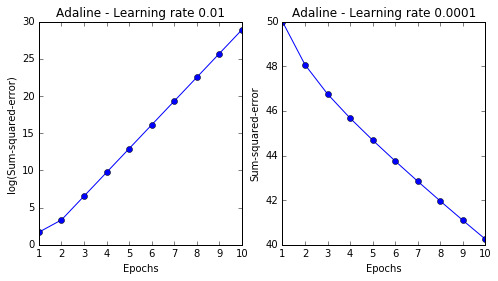

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reloading the database again since this is a new notebook
df = pd.read_csv('iris.data', header=None)
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0,2]].values

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter = 10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter = 10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

As we can see above, if we choose a learning rate too large, the algorithm will never converge, as the global minimum occured in the middle of a learning period, which causes us to miss it every time, thus rendering our algorithm useless. On the other hand, having a learning rate too small will cause increase the number of epochs it takes for an algorithm to converge, which reduces performance and efficiency. To achieve optimal performance, we will need to apply some form of feature scaling, more specifically <b><i>standardization</i></b> for this example. The formula for standardizing a specific feature $j$ is: 
                                    $$x^{'}_j=\frac{x_j-\mu_j}{\sigma_j}$$
where $\mu_j$ is the mean of the $j^{th}$ sample and $\sigma_j$ is the standard deviation. Exact use of standardization will be discussed at a later chapter, but for now we know that this process "gives our data the property of a standard normal distribution". In python the above formula is fairly easy to implement.

In [8]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

I like how above code is almost word for word when compared with the formula, and that makes it clear and easy to read. With our two features standardized, we can now train our adaline again and see if it now converges even with the larger learning rate. Below also is <code>plot_decision_regions()</code> function definition from last notebook.

In [17]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decison surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha = 0.8, c=cmap(idx),
                   marker=markers[idx], label=cl)

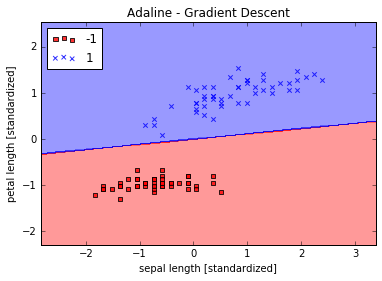

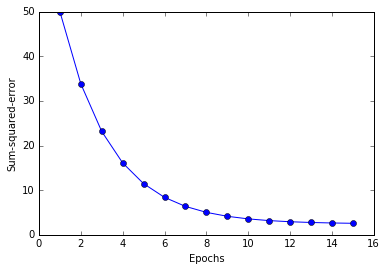

In [18]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.show()

From the two plots above, we can see the decision boundary created by the algorithm and cost function declining as number of Epochs increase, which is our desired effect. One thing I noticed is that even with all the samples classified correctly, Sum-squared-error is still not exactly 0, so there must be some error somewhere along the training, but it is negligible and did not affect the overall accuracy.